## Data Prepping/Cleaning

In [117]:
import pandas as pd
import numpy as np

In [118]:
df = pd.read_csv('0_df_long.csv', sep=';', decimal=',')
df

,KabKot,Tahun,Bulan,Produk,Harga,Kategori,KodeBPS,KodeProv,NamaProv
0,Kab. Aceh Barat,2022,Januari,Beras Premium,11429,Beras,11.05,11,Aceh
1,Kab. Aceh Barat,2022,Januari,Beras Medium,9979,Beras,11.05,11,Aceh
2,Kab. Aceh Barat,2022,Januari,Bawang Merah,31000,Bawang,11.05,11,Aceh
3,Kab. Aceh Barat,2022,Januari,Bawang Putih (Bonggol),28636,Bawang,11.05,11,Aceh
4,Kab. Aceh Barat,2022,Januari,Cabai Merah Keriting,19409,Cabai,11.05,11,Aceh
...,...,...,...,...,...,...,...,...,...
340615,Kota Yogyakarta,2025,Oktober,Minyak Goreng Kemasan,19100,MinyakGoreng,34.71,34,DI Yogyakarta
340616,Kota Yogyakarta,2025,Oktober,Minyak Goreng Curah,17161,MinyakGoreng,34.71,34,DI Yogyakarta
340617,Kota Yogyakarta,2025,Oktober,Jagung Tk. Peternak,NaN,Jagung,34.71,34,DI Yogyakarta
340618,Kota Yogyakarta,2025,Oktober,Cabai Merah Besar,48304,Cabai,34.71,34,DI Yogyakarta


In [119]:
month_map = {
    "Januari":   1,
    "Februari":  2,
    "Maret":     3,
    "April":     4,
    "Mei":       5,
    "Juni":      6,
    "Juli":      7,
    "Agustus":   8,
    "September": 9,
    "Oktober":   10,
    "November":  11,
    "Desember":  12,
}

df["Bulan_norm"] = df["Bulan"].str.strip().str.title()
df["MonthNum"] = df["Bulan_norm"].map(month_map)

df["Tanggal"] = pd.to_datetime(
    dict(year=df["Tahun"].astype(int),
         month=df["MonthNum"].astype(int),
         day=1)
)

df = df.sort_values(["KabKot", "Produk", "Tanggal"]).reset_index(drop=True)
df

,KabKot,Tahun,Bulan,Produk,Harga,Kategori,KodeBPS,KodeProv,NamaProv,Bulan_norm,MonthNum,Tanggal
0,Kab. Aceh Barat,2022,Januari,Bawang Merah,31000,Bawang,11.05,11,Aceh,Januari,1,2022-01-01
1,Kab. Aceh Barat,2022,Februari,Bawang Merah,33107,Bawang,11.05,11,Aceh,Februari,2,2022-02-01
2,Kab. Aceh Barat,2022,Maret,Bawang Merah,37600,Bawang,11.05,11,Aceh,Maret,3,2022-03-01
3,Kab. Aceh Barat,2022,April,Bawang Merah,35800,Bawang,11.05,11,Aceh,April,4,2022-04-01
4,Kab. Aceh Barat,2022,Mei,Bawang Merah,41600,Bawang,11.05,11,Aceh,Mei,5,2022-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...
340615,Kota Yogyakarta,2025,Juni,Telur Ayam Ras,27565,Protein,34.71,34,DI Yogyakarta,Juni,6,2025-06-01
340616,Kota Yogyakarta,2025,Juli,Telur Ayam Ras,27486,Protein,34.71,34,DI Yogyakarta,Juli,7,2025-07-01
340617,Kota Yogyakarta,2025,Agustus,Telur Ayam Ras,26903,Protein,34.71,34,DI Yogyakarta,Agustus,8,2025-08-01
340618,Kota Yogyakarta,2025,September,Telur Ayam Ras,27413,Protein,34.71,34,DI Yogyakarta,September,9,2025-09-01


### Handling NaN Values

In [120]:
def fill_harga(group):
    group = group.sort_values("Tanggal").copy()

    s = group["Harga"].astype("float64").copy()

    if pd.isna(s.iloc[0]):
        s.iloc[0] = s.bfill().iloc[0]

    vals = s.to_numpy(dtype="float64")
    n = len(vals)
    i = 0

    while i < n:
        if np.isnan(vals[i]):
            start = i
            while i < n and np.isnan(vals[i]):
                i += 1
            end = i - 1

            prev_val = vals[start - 1] if start > 0 and not np.isnan(vals[start - 1]) else None
            next_val = vals[i] if i < n and not np.isnan(vals[i]) else None

            if prev_val is not None and next_val is not None:
                fill_val = (prev_val + next_val) / 2.0
            elif prev_val is not None:
                fill_val = prev_val
            elif next_val is not None:
                fill_val = next_val
            else:
                fill_val = np.nan

            vals[start:end+1] = fill_val
        else:
            i += 1

    group["Harga_filled"] = vals
    return group

In [121]:
group_cols = ["KabKot", "Produk"]

df = (
    df
    .groupby(group_cols, group_keys=False)[df.columns]
    .apply(fill_harga)
)

df["Harga"] = df["Harga_filled"]
df = df.drop(columns=["Harga_filled", "Bulan_norm", "MonthNum"])
df

,KabKot,Tahun,Bulan,Produk,Harga,Kategori,KodeBPS,KodeProv,NamaProv,Tanggal
0,Kab. Aceh Barat,2022,Januari,Bawang Merah,31000.0,Bawang,11.05,11,Aceh,2022-01-01
1,Kab. Aceh Barat,2022,Februari,Bawang Merah,33107.0,Bawang,11.05,11,Aceh,2022-02-01
2,Kab. Aceh Barat,2022,Maret,Bawang Merah,37600.0,Bawang,11.05,11,Aceh,2022-03-01
3,Kab. Aceh Barat,2022,April,Bawang Merah,35800.0,Bawang,11.05,11,Aceh,2022-04-01
4,Kab. Aceh Barat,2022,Mei,Bawang Merah,41600.0,Bawang,11.05,11,Aceh,2022-05-01
...,...,...,...,...,...,...,...,...,...,...
340615,Kota Yogyakarta,2025,Juni,Telur Ayam Ras,27565.0,Protein,34.71,34,DI Yogyakarta,2025-06-01
340616,Kota Yogyakarta,2025,Juli,Telur Ayam Ras,27486.0,Protein,34.71,34,DI Yogyakarta,2025-07-01
340617,Kota Yogyakarta,2025,Agustus,Telur Ayam Ras,26903.0,Protein,34.71,34,DI Yogyakarta,2025-08-01
340618,Kota Yogyakarta,2025,September,Telur Ayam Ras,27413.0,Protein,34.71,34,DI Yogyakarta,2025-09-01


In [122]:
df["Harga"].isna().sum()


8896

In [123]:
df.groupby(["KabKot", "Produk"])["Harga"].apply(lambda s: s.isna().sum()).sort_values(ascending=False)


KabKot                   Produk               
Kab. Samosir             Cabai Merah Besar        46
Kab. Pakpak Bharat       Cabai Merah Besar        46
Kab. Kepulauan Anambas   Cabai Merah Besar        46
Kab. Padang Lawas Utara  Cabai Merah Besar        46
Kab. Kepulauan Anambas   Jagung Tk. Peternak      46
                                                  ..
Kab. Kuantan Singingi    Minyak Goreng Kemasan     0
                         Minyak Goreng Curah       0
                         Jagung Tk. Peternak       0
                         Gula Konsumsi             0
Kota Yogyakarta          Telur Ayam Ras            0
Name: Harga, Length: 7590, dtype: int64

In [124]:
all_nan_groups = (
    df.groupby(["KabKot", "Produk"])["Harga"]
      .apply(lambda s: s.isna().all())
)

print(all_nan_groups.index.tolist())


[('Kab. Aceh Barat', 'Bawang Merah'), ('Kab. Aceh Barat', 'Bawang Putih (Bonggol)'), ('Kab. Aceh Barat', 'Beras Medium'), ('Kab. Aceh Barat', 'Beras Premium'), ('Kab. Aceh Barat', 'Cabai Merah Besar'), ('Kab. Aceh Barat', 'Cabai Merah Keriting'), ('Kab. Aceh Barat', 'Cabai Rawit Merah'), ('Kab. Aceh Barat', 'Daging Ayam Ras'), ('Kab. Aceh Barat', 'Daging Sapi Murni'), ('Kab. Aceh Barat', 'Gula Konsumsi'), ('Kab. Aceh Barat', 'Jagung Tk. Peternak'), ('Kab. Aceh Barat', 'Minyak Goreng Curah'), ('Kab. Aceh Barat', 'Minyak Goreng Kemasan'), ('Kab. Aceh Barat', 'Minyakita'), ('Kab. Aceh Barat', 'Telur Ayam Ras'), ('Kab. Aceh Barat Daya', 'Bawang Merah'), ('Kab. Aceh Barat Daya', 'Bawang Putih (Bonggol)'), ('Kab. Aceh Barat Daya', 'Beras Medium'), ('Kab. Aceh Barat Daya', 'Beras Premium'), ('Kab. Aceh Barat Daya', 'Cabai Merah Besar'), ('Kab. Aceh Barat Daya', 'Cabai Merah Keriting'), ('Kab. Aceh Barat Daya', 'Cabai Rawit Merah'), ('Kab. Aceh Barat Daya', 'Daging Ayam Ras'), ('Kab. Aceh Bara

In [125]:
total_nan = df["Harga"].isna().sum()

nan_in_all_nan_groups = (
    df.groupby(["KabKot", "Produk"])["Harga"]
      .apply(lambda s: s.isna().sum() if s.isna().all() else 0)
      .sum()
)

print("Total NaN in Harga:", total_nan)
print("NaN in all-NaN groups:", nan_in_all_nan_groups)


Total NaN in Harga: 8896
NaN in all-NaN groups: 8896


In [126]:
fully_nan_index = all_nan_groups[all_nan_groups].index   # MultiIndex of combos to drop

df = df[~df.set_index(["KabKot", "Produk"]).index.isin(fully_nan_index)].reset_index(drop=True)

print("Remaining NaNs:", df["Harga"].isna().sum())


Remaining NaNs: 0


### Aggregate by Province

In [127]:
df_prov = (
    df.groupby(["NamaProv", "Produk", "Tanggal", "Kategori"], as_index=False)["Harga"]
      .mean()
      .rename(columns={"Harga": "Harga_prov"})
)
df_prov


,NamaProv,Produk,Tanggal,Kategori,Harga_prov
0,Aceh,Bawang Merah,2022-01-01,Bawang,30192.956522
1,Aceh,Bawang Merah,2022-02-01,Bawang,32474.956522
2,Aceh,Bawang Merah,2022-03-01,Bawang,36235.913043
3,Aceh,Bawang Merah,2022-04-01,Bawang,34477.695652
4,Aceh,Bawang Merah,2022-05-01,Bawang,37444.173913
...,...,...,...,...,...
22765,Sumatera Utara,Telur Ayam Ras,2025-06-01,Protein,28156.242424
22766,Sumatera Utara,Telur Ayam Ras,2025-07-01,Protein,28483.484848
22767,Sumatera Utara,Telur Ayam Ras,2025-08-01,Protein,29128.515152
22768,Sumatera Utara,Telur Ayam Ras,2025-09-01,Protein,28886.606061


### Aggregate by Category (except Protein)

In [128]:
kat_norm = df_prov["Kategori"].str.strip().str.lower()

df_prov["KatAgg"] = np.where(
    kat_norm == "protein",
    df_prov["Produk"],
    df_prov["Kategori"]
)

df_prov["KatAgg"].value_counts()

KatAgg
Cabai                4554
MinyakGoreng         4554
Bawang               3036
Beras                3036
Daging Ayam Ras      1518
Daging Sapi Murni    1518
Gula                 1518
Jagung               1518
Telur Ayam Ras       1518
Name: count, dtype: int64

In [129]:
df_prov_kat = (
    df_prov
    .groupby(["NamaProv", "KatAgg", "Tanggal"], as_index=False)["Harga_prov"]
    .mean()
)

df_prov_kat = df_prov_kat.rename(columns={"KatAgg": "KategoriAgg", "Harga_prov": "Harga"})

df_prov_kat

,NamaProv,KategoriAgg,Tanggal,Harga
0,Aceh,Bawang,2022-01-01,29488.130435
1,Aceh,Bawang,2022-02-01,31136.891304
2,Aceh,Bawang,2022-03-01,33484.847826
3,Aceh,Bawang,2022-04-01,32411.413043
4,Aceh,Bawang,2022-05-01,33122.065217
...,...,...,...,...
13657,Sumatera Utara,Telur Ayam Ras,2025-06-01,28156.242424
13658,Sumatera Utara,Telur Ayam Ras,2025-07-01,28483.484848
13659,Sumatera Utara,Telur Ayam Ras,2025-08-01,29128.515152
13660,Sumatera Utara,Telur Ayam Ras,2025-09-01,28886.606061


## Clustering by Province for the 3 Staples in Indonesia (Beras, Minyak Goreng, Gula)

In [130]:
df_mean = (
    df_prov_kat
    .groupby(["NamaProv", "KategoriAgg"], as_index=False)["Harga"]
    .mean()
)
df_mean

,NamaProv,KategoriAgg,Harga
0,Aceh,Bawang,36063.788280
1,Aceh,Beras,13106.139650
2,Aceh,Cabai,54320.470857
3,Aceh,Daging Ayam Ras,31000.022684
4,Aceh,Daging Sapi Murni,155159.618620
...,...,...,...
292,Sumatera Utara,Daging Sapi Murni,134226.774909
293,Sumatera Utara,Gula,16340.874197
294,Sumatera Utara,Jagung,6470.319221
295,Sumatera Utara,MinyakGoreng,17513.059855


In [131]:
df_mean['NamaProv'].unique()

array(['Aceh', 'Bali', 'Banten', 'Bengkulu', 'DI Yogyakarta',
       'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah',
       'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur',
       'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung', 'Maluku',
       'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Papua', 'Papua Barat', 'Riau', 'Sulawesi Barat',
       'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara',
       'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan',
       'Sumatera Utara'], dtype=object)

In [132]:
kategori_vars = [
    "Cabai",
    "MinyakGoreng",
    "Bawang",
    "Beras",
    "Daging Ayam Ras",
    "Daging Sapi Murni",
    "Gula",
    "Jagung",
    "Telur Ayam Ras",
]

df_wide = (
    df_mean
    .pivot(index="NamaProv", columns="KategoriAgg", values="Harga")
    .reindex(columns=kategori_vars)
    .dropna(how="any")
)

df_wide.columns.name = None
df_wide.reset_index(inplace=True)

df_wide

,NamaProv,Cabai,MinyakGoreng,Bawang,Beras,Daging Ayam Ras,Daging Sapi Murni,Gula,Jagung,Telur Ayam Ras
0,Aceh,54320.470857,17458.559861,36063.788280,13106.139650,31000.022684,155159.618620,16595.759924,9749.590062,25510.955577
1,Bali,49871.663446,17570.915459,30700.663043,13471.057971,39119.442029,116455.262077,15703.053140,6403.250000,26648.654589
2,Banten,54000.285326,16630.185688,35433.302989,12640.846467,36883.491848,135418.877717,15886.100543,7569.690217,27538.630435
3,Bengkulu,48277.342874,17145.202174,35810.206522,13094.213043,35562.250000,135652.913043,16154.930435,8322.077899,26252.504348
4,DI Yogyakarta,48319.818841,16605.723188,32676.954348,12668.128261,34110.934783,135182.600000,15521.795652,7225.254348,26933.243478
5,DKI Jakarta,61785.514010,18089.926087,41348.268116,13221.505435,38442.547101,138140.181159,16441.163043,12000.000000,28494.902174
6,Gorontalo,43609.997585,17993.580314,40780.827899,13233.320652,32144.090580,134322.250000,16974.612319,21000.000000,31204.420290
7,Jambi,47516.979513,16742.265810,32013.446640,12979.431818,34038.357708,137639.837945,15931.023715,7081.027950,27529.211462
8,Jawa Barat,54069.657903,17680.000939,34949.324074,12789.855878,36230.452496,133186.580918,16070.256844,6844.207776,27940.276973
9,Jawa Tengah,47031.509553,16955.915238,33300.128087,12870.308925,35262.443609,129891.859153,15479.226400,6149.782601,26975.606961


In [133]:
df_wide_staples = df_wide[["NamaProv", "Beras", "Gula", "MinyakGoreng"]]
df_wide_staples

,NamaProv,Beras,Gula,MinyakGoreng
0,Aceh,13106.139650,16595.759924,17458.559861
1,Bali,13471.057971,15703.053140,17570.915459
2,Banten,12640.846467,15886.100543,16630.185688
3,Bengkulu,13094.213043,16154.930435,17145.202174
4,DI Yogyakarta,12668.128261,15521.795652,16605.723188
5,DKI Jakarta,13221.505435,16441.163043,18089.926087
6,Gorontalo,13233.320652,16974.612319,17993.580314
7,Jambi,12979.431818,15931.023715,16742.265810
8,Jawa Barat,12789.855878,16070.256844,17680.000939
9,Jawa Tengah,12870.308925,15479.226400,16955.915238


### Quick EDA

Shape: (33, 4)

Index name: None
Columns: ['NamaProv', 'Beras', 'Gula', 'MinyakGoreng']

Head:
        NamaProv         Beras          Gula  MinyakGoreng
0           Aceh  13106.139650  16595.759924  17458.559861
1           Bali  13471.057971  15703.053140  17570.915459
2         Banten  12640.846467  15886.100543  16630.185688
3       Bengkulu  13094.213043  16154.930435  17145.202174
4  DI Yogyakarta  12668.128261  15521.795652  16605.723188

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NamaProv      33 non-null     object 
 1   Beras         33 non-null     float64
 2   Gula          33 non-null     float64
 3   MinyakGoreng  33 non-null     float64
dtypes: float64(3), object(1)
memory usage: 1.2+ KB
None

Missing values per column:
NamaProv        0
Beras           0
Gula            0
MinyakGoreng    0
dtype: int64

Descrip

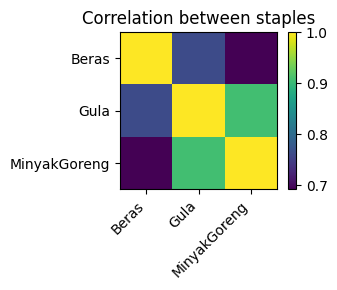

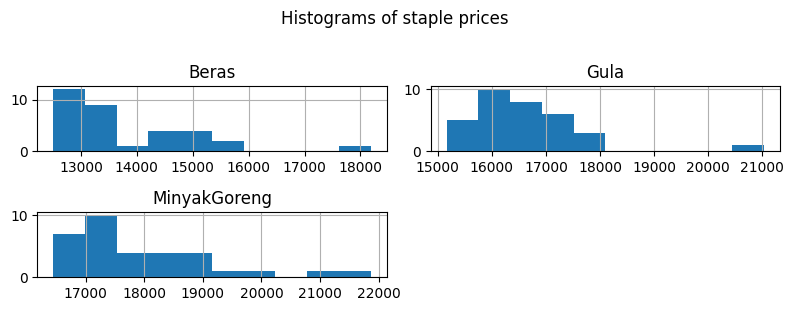

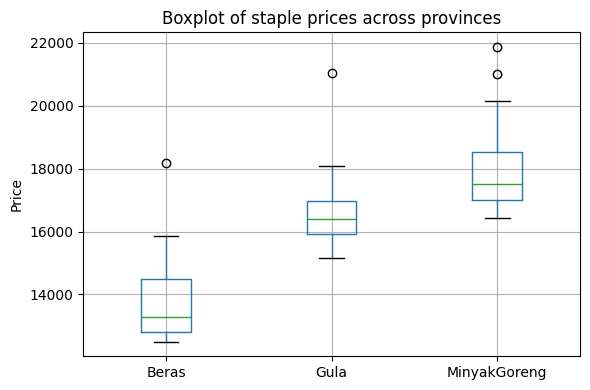

<Figure size 600x600 with 0 Axes>

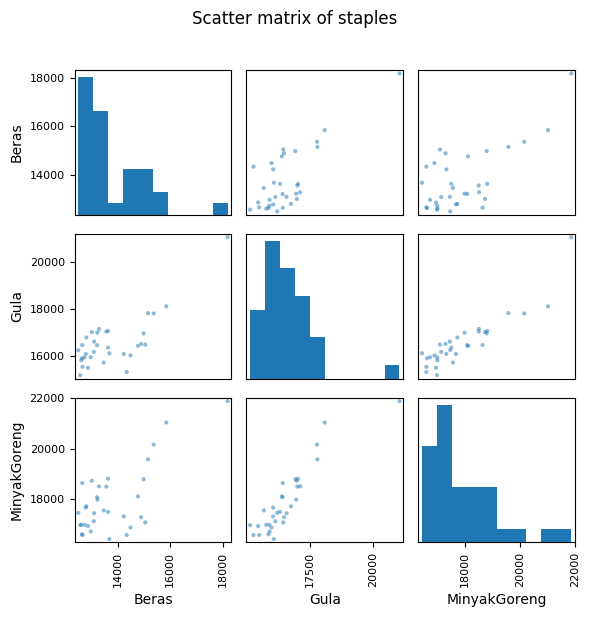

In [134]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# =========================
# 1. Basic structure
# =========================
print("Shape:", df_wide_staples.shape)
print("\nIndex name:", df_wide_staples.index.name)
print("Columns:", df_wide_staples.columns.tolist())

print("\nHead:")
print(df_wide_staples.head())

print("\nBasic info:")
print(df_wide_staples.info())

# =========================
# 2. Missing values
# =========================
print("\nMissing values per column:")
print(df_wide_staples.isna().sum())

# =========================
# 3. Summary statistics
# =========================
print("\nDescriptive statistics:")
print(df_wide_staples.describe().T)  # transpose for readability

# =========================
# 4. Correlation between staples
# =========================
corr = df_wide_staples.drop(columns=['NamaProv']).corr()
print("\nCorrelation matrix:")
print(corr)

plt.figure(figsize=(4, 3))
im = plt.imshow(corr, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation between staples")
plt.tight_layout()
plt.show()

# =========================
# 5. Distributions (histograms)
# =========================
df_wide_staples.hist(figsize=(8, 3), bins=10)
plt.suptitle("Histograms of staple prices", y=1.02)
plt.tight_layout()
plt.show()

# =========================
# 6. Boxplots per variable
# =========================
plt.figure(figsize=(6, 4))
df_wide_staples.boxplot()
plt.title("Boxplot of staple prices across provinces")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

# =========================
# 7. Scatter matrix (pairwise scatter plots)
# =========================
plt.figure(figsize=(6, 6))
scatter_matrix(df_wide_staples, figsize=(6, 6), diagonal="hist")
plt.suptitle("Scatter matrix of staples", y=1.02)
plt.tight_layout()
plt.show()


# Interpretasi EDA

## 1. Struktur Data

- Jumlah observasi: **33 provinsi**.
- Variabel:
  - **Beras**
  - **MinyakGoreng**
  - **Gula**

---

## 2. Gambaran Umum Tingkat Harga

Ringkasan statistik (dalam satuan harga rata-rata selama periode pengamatan):

- **Beras**
  - Rata-rata: ± **13.763**
  - Sebaran (std): ± 1.246
  - Rentang: dari sekitar **12.504** sampai **18.183**

- **MinyakGoreng**
  - Rata-rata: ± **17.910**
  - Sebaran (std): ± 1.280
  - Rentang: dari sekitar **16.446** sampai **21.866**

- **Gula**
  - Rata-rata: ± **16.550**
  - Sebaran (std): ± 1.069
  - Rentang: dari sekitar **15.164** sampai **21.035**

Secara umum:
- Minyak goreng memiliki **level harga rata-rata tertinggi** di antara tiga komoditas pokok.
- Beras merupakan komoditas dengan **level harga rata-rata terendah**, namun tetap menunjukkan variasi antardaerah yang cukup terasa.
- Gula berada di tengah-tengah, baik dari sisi rata-rata maupun sebaran.

Outlier terlihat pada beberapa provinsi dengan harga jauh di atas rata-rata, terutama:
- Beras di kisaran > 17–18 ribu,
- Minyak goreng di kisaran > 20–21 ribu,
- Gula di kisaran > 19–21 ribu.

Ini menunjukkan adanya beberapa provinsi dengan **beban harga pangan yang jauh lebih tinggi** dibanding provinsi lain.

---

## 3. Distribusi Harga antar Provinsi

Dari histogram dan boxplot:

- **Beras**
  - Distribusi sedikit condong ke kanan (right-skewed): sebagian besar provinsi berada di kisaran 12–14 ribu, dengan beberapa provinsi yang jauh lebih mahal sehingga menjadi outlier.
  - Menunjukkan bahwa **mayoritas provinsi memiliki harga beras relatif terkendali**, namun ada sedikit kelompok yang benar-benar mahal.

- **MinyakGoreng**
  - Distribusi juga condong ke kanan, dengan beberapa titik outlier di atas 20 ribu.
  - Menunjukkan adanya **ketimpangan harga minyak goreng** yang cukup jelas antarprovinsi.

- **Gula**
  - Pola mirip: mayoritas provinsi di sekitar 15,5–17 ribu, dengan sedikit provinsi yang sangat mahal.
  - Ini konsisten dengan komoditas yang diawasi ketat, tetapi tetap ada variasi cukup lebar di daerah tertentu.

Secara praktis, ketiga komoditas menunjukkan pola bahwa **sebagian besar provinsi berada di “cluster harga tengah”**, sedangkan sejumlah kecil provinsi “menarik” ekor distribusi ke arah harga tinggi.

---

## 4. Korelasi Antar Komoditas

Matriks korelasi menunjukkan:

- **Beras – MinyakGoreng**: ~ **0.69**
- **Beras – Gula**: ~ **0.76**
- **MinyakGoreng – Gula**: ~ **0.91** (sangat tinggi)

Interpretasi:

1. Korelasi positif yang cukup kuat antar semua pasangan komoditas menunjukkan bahwa:
   - Provinsi yang **mahal di satu komoditas** cenderung **mahal juga** di komoditas lainnya.
   - Ada indikasi **pola umum biaya hidup pangan pokok** yang bergerak bersama.

2. Korelasi yang **paling kuat** adalah antara **MinyakGoreng dan Gula (~0.91)**:
   - Mengindikasikan bahwa kedua komoditas ini sangat sejalan dalam hal tingkat harga antarprovinsi.
   - Provinsi yang mengalami kenaikan harga minyak goreng hampir selalu juga memiliki harga gula yang relatif tinggi.

3. Beras juga berkorelasi kuat dengan Gula dan MinyakGoreng, meskipun sedikit lebih rendah dibanding hubungan minyak–gula:
   - Ini mendukung interpretasi bahwa ketiga komoditas tersebut bersama-sama dapat dijadikan indikator **keterjangkauan pangan pokok** di tingkat provinsi.


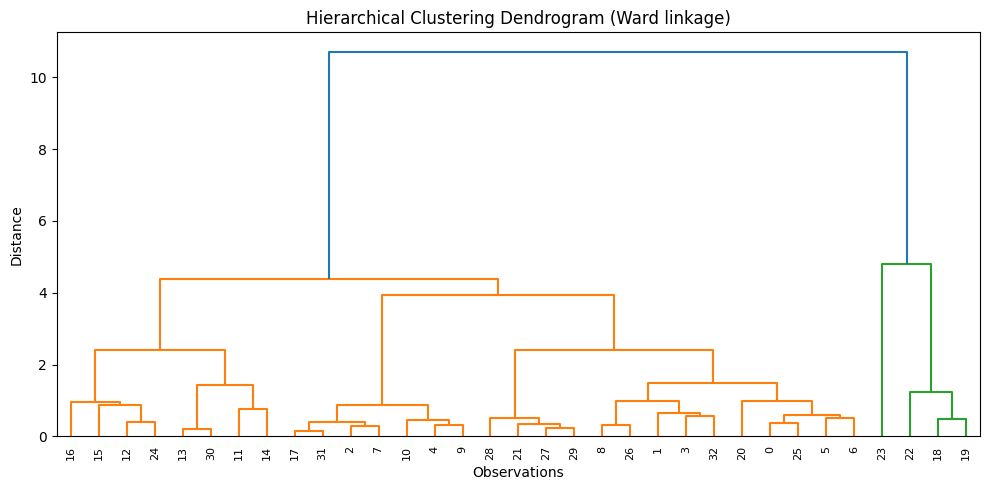

In [135]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

try:
    labels = df_wide_staples.index.astype(str)
except NameError:
    labels = None  # fallback if df_wide_staples isn't defined

# Ward linkage on the scaled data
Z = linkage(X_scaled, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


### K-Means clustering

In [136]:
from sklearn.preprocessing import StandardScaler

X = df_wide_staples.drop(columns=['NamaProv']).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

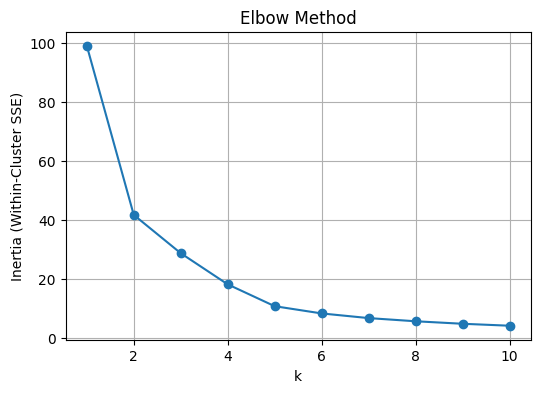

In [137]:
from sklearn.cluster import KMeans

inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.title("Elbow Method")
plt.grid(True)
plt.show()


In [138]:
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

sil_scores


{2: 0.6330350594788052,
 3: 0.5238814464300645,
 4: 0.348344920706667,
 5: 0.4254056180778093,
 6: 0.39609971509347314,
 7: 0.3543051450804735,
 8: 0.32965281864437873,
 9: 0.3463317014244102,
 10: 0.31335748127390683}

In [139]:
best_k = 3

kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=0)
labels_kmeans = kmeans.fit_predict(X_scaled)


In [140]:
df_clusters = df_wide_staples.copy()
df_clusters["kmeans_cluster"] = labels_kmeans

df_clusters[['NamaProv', 'kmeans_cluster']]

,NamaProv,kmeans_cluster
0,Aceh,1
1,Bali,1
2,Banten,1
3,Bengkulu,1
4,DI Yogyakarta,1
5,DKI Jakarta,1
6,Gorontalo,1
7,Jambi,1
8,Jawa Barat,1
9,Jawa Tengah,1


In [141]:
cluster_profile = (
    df_clusters
    .groupby("kmeans_cluster")[df_wide_staples.drop(columns=['NamaProv']).columns]
    .mean()
)

cluster_profile

,Beras,Gula,MinyakGoreng
kmeans_cluster,,,
0,18182.524093,21035.431396,21865.976632
1,13379.110819,16231.243079,17486.203535
2,15341.410204,17660.843069,19888.039909


### K-medoids

In [142]:
from sklearn.metrics import pairwise_distances


def k_medoids_pam(X, n_clusters, metric="euclidean", max_iter=300, random_state=None):
    """
    Simple K-medoids (PAM) implementation.
    X: (n_samples, n_features)
    Returns:
        labels: (n_samples,) cluster labels
        medoid_indices: list of indices of chosen medoids
        inertia: sum of distances of each point to its assigned medoid
    """
    rng = np.random.default_rng(random_state)
    n_samples = X.shape[0]

    # precompute distance matrix
    D = pairwise_distances(X, metric=metric)

    # --- init: pick n_clusters distinct random medoids ---
    medoid_indices = rng.choice(n_samples, size=n_clusters, replace=False)
    medoid_indices = np.sort(medoid_indices)

    for _ in range(max_iter):
        # assign each point to nearest medoid
        distances_to_medoids = D[:, medoid_indices]          # (n_samples, k)
        labels = distances_to_medoids.argmin(axis=1)

        new_medoids = medoid_indices.copy()

        # update step: for each cluster, choose the point that minimizes total distance in that cluster
        for k in range(n_clusters):
            cluster_points = np.where(labels == k)[0]
            if len(cluster_points) == 0:
                # empty cluster: reinitialize medoid randomly
                non_medoids = np.setdiff1d(np.arange(n_samples), new_medoids)
                if len(non_medoids) > 0:
                    new_medoids[k] = rng.choice(non_medoids)
                continue

            # distances within the cluster
            D_cluster = D[np.ix_(cluster_points, cluster_points)]
            # total distance from each point to others in cluster
            total_dist = D_cluster.sum(axis=1)
            # pick cluster point with minimum total distance as new medoid
            best_idx_in_cluster = cluster_points[total_dist.argmin()]
            new_medoids[k] = best_idx_in_cluster

        new_medoids = np.sort(new_medoids)

        # stop if medoids don't change
        if np.array_equal(new_medoids, medoid_indices):
            break

        medoid_indices = new_medoids

    # final assignment and inertia
    distances_to_medoids = D[:, medoid_indices]
    labels = distances_to_medoids.argmin(axis=1)
    inertia = distances_to_medoids.min(axis=1).sum()

    return labels, medoid_indices, inertia


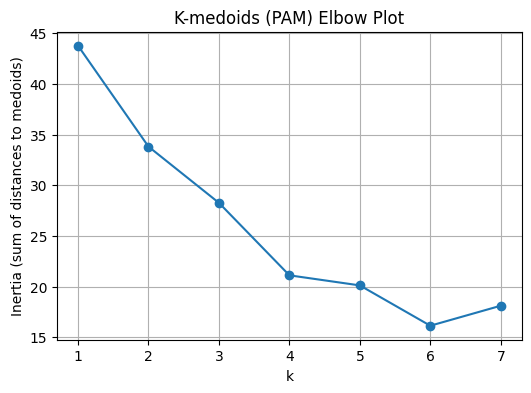

In [143]:
inertias = []
K_range = range(1, 8)

for k in K_range:
    labels_k, medoids_k, inertia_k = k_medoids_pam(
        X_scaled,
        n_clusters=k,
        metric="euclidean",
        max_iter=300,
        random_state=0
    )
    inertias.append(inertia_k)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (sum of distances to medoids)")
plt.title("K-medoids (PAM) Elbow Plot")
plt.grid(True)
plt.show()


In [144]:
from sklearn.metrics import silhouette_score

sil_scores = {}
for k in range(2, 8):
    labels_k, medoids_k, inertia_k = k_medoids_pam(
        X_scaled,
        n_clusters=k,
        metric="euclidean",
        max_iter=300,
        random_state=0
    )
    sil = silhouette_score(X_scaled, labels_k)
    sil_scores[k] = sil

sil_scores


{2: 0.39932670456977254,
 3: 0.25519394309810217,
 4: 0.39891511660740975,
 5: 0.2821516691715415,
 6: 0.3488234525764815,
 7: 0.14955119043901846}

In [145]:
best_k = 4
labels_kmedoids, medoid_indices, inertia = k_medoids_pam(
    X_scaled,
    n_clusters=best_k,
    metric="euclidean",
    max_iter=300,
    random_state=0
)

df_clusters["kmed_cluster"] = labels_kmedoids
df_clusters = df_clusters.reset_index()  # bring NamaProv out


In [146]:
prov_names = df_wide.index.to_list()
medoid_provinces = [prov_names[i] for i in medoid_indices]
medoid_provinces


[6, 12, 17, 19]

In [147]:
df_clusters[['NamaProv', 'kmeans_cluster', 'kmed_cluster']]

,NamaProv,kmeans_cluster,kmed_cluster
0,Aceh,1,0
1,Bali,1,2
2,Banten,1,2
3,Bengkulu,1,2
4,DI Yogyakarta,1,2
5,DKI Jakarta,1,0
6,Gorontalo,1,0
7,Jambi,1,2
8,Jawa Barat,1,2
9,Jawa Tengah,1,2


In [148]:
cluster_profile_kmed = (
    df_clusters
    .groupby("kmed_cluster")[df_wide_staples.drop(columns=['NamaProv']).columns]
    .mean()
)
cluster_profile_kmed


,Beras,Gula,MinyakGoreng
kmed_cluster,,,
0,13218.642781,16777.169978,18200.498959
1,14496.290563,16120.696394,17115.136529
2,12814.058290,15805.293789,17072.977608
3,15909.632981,18335.760735,20283.627253


## Evaluation of the 2 Clustering Methods

In [149]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    pairwise_distances,
)

# ---------------------------------------------------------
# 7. Evaluate performance of each clustering
# ---------------------------------------------------------

# KMeans metrics
sil_km = silhouette_score(X_scaled, labels_kmeans)
ch_km = calinski_harabasz_score(X_scaled, labels_kmeans)
db_km = davies_bouldin_score(X_scaled, labels_kmeans)

# K-medoids metrics
sil_kmed = silhouette_score(X_scaled, labels_kmedoids)
ch_kmed = calinski_harabasz_score(X_scaled, labels_kmedoids)
db_kmed = davies_bouldin_score(X_scaled, labels_kmedoids)

print("=== KMeans (k=3) ===")
print(f"Silhouette score        : {sil_km:.4f}")
print(f"Calinski-Harabasz index : {ch_km:.4f}")
print(f"Davies-Bouldin index    : {db_km:.4f}")

print("\n=== K-medoids (k=4) ===")
print(f"Silhouette score        : {sil_kmed:.4f}")
print(f"Calinski-Harabasz index : {ch_kmed:.4f}")
print(f"Davies-Bouldin index    : {db_kmed:.4f}")

df_clusters


=== KMeans (k=3) ===
Silhouette score        : 0.5239
Calinski-Harabasz index : 36.9209
Davies-Bouldin index    : 0.4310

=== K-medoids (k=4) ===
Silhouette score        : 0.3989
Calinski-Harabasz index : 28.3010
Davies-Bouldin index    : 0.7159


,index,NamaProv,Beras,Gula,MinyakGoreng,kmeans_cluster,kmed_cluster
0,0,Aceh,13106.139650,16595.759924,17458.559861,1,0
1,1,Bali,13471.057971,15703.053140,17570.915459,1,2
2,2,Banten,12640.846467,15886.100543,16630.185688,1,2
3,3,Bengkulu,13094.213043,16154.930435,17145.202174,1,2
4,4,DI Yogyakarta,12668.128261,15521.795652,16605.723188,1,2
5,5,DKI Jakarta,13221.505435,16441.163043,18089.926087,1,0
6,6,Gorontalo,13233.320652,16974.612319,17993.580314,1,0
7,7,Jambi,12979.431818,15931.023715,16742.265810,1,2
8,8,Jawa Barat,12789.855878,16070.256844,17680.000939,1,2
9,9,Jawa Tengah,12870.308925,15479.226400,16955.915238,1,2


In [150]:
df_clusters.groupby("kmeans_cluster")[["Beras", "MinyakGoreng", "Gula"]].mean()


,Beras,MinyakGoreng,Gula
kmeans_cluster,,,
0,18182.524093,21865.976632,21035.431396
1,13379.110819,17486.203535,16231.243079
2,15341.410204,19888.039909,17660.843069


In [151]:
df_clusters.groupby("kmed_cluster")[["Beras", "MinyakGoreng", "Gula"]].mean()

,Beras,MinyakGoreng,Gula
kmed_cluster,,,
0,13218.642781,18200.498959,16777.169978
1,14496.290563,17115.136529,16120.696394
2,12814.058290,17072.977608,15805.293789
3,15909.632981,20283.627253,18335.760735


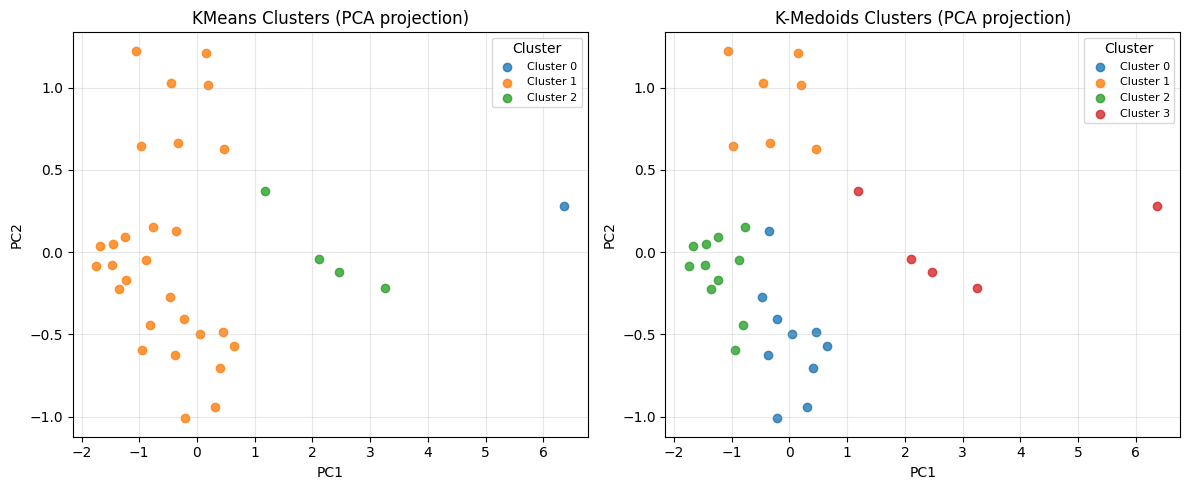

In [152]:
from sklearn.decomposition import PCA

# =======================================
# 1. Project to 2D with PCA (for plotting)
# =======================================
# Assumes X_scaled is aligned with df_clusters (same row order)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # shape (n_samples, 2)

# Optional: put PCA coords into the df for easier inspection
df_clusters_plot = df_clusters.copy()
df_clusters_plot["PC1"] = X_pca[:, 0]
df_clusters_plot["PC2"] = X_pca[:, 1]

# =======================================
# 2. Plot KMeans vs K-Medoids side by side
# =======================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---------- KMeans ----------
ax = axes[0]
col_km = "kmeans_cluster"

for c in sorted(df_clusters_plot[col_km].unique()):
    mask = df_clusters_plot[col_km] == c
    ax.scatter(
        df_clusters_plot.loc[mask, "PC1"],
        df_clusters_plot.loc[mask, "PC2"],
        label=f"Cluster {c}",
        alpha=0.8,
    )

ax.set_title("KMeans Clusters (PCA projection)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True, alpha=0.3)
ax.legend(title="Cluster", fontsize=8)

# ---------- K-Medoids ----------
ax = axes[1]
col_kmed = "kmed_cluster"

for c in sorted(df_clusters_plot[col_kmed].unique()):
    mask = df_clusters_plot[col_kmed] == c
    ax.scatter(
        df_clusters_plot.loc[mask, "PC1"],
        df_clusters_plot.loc[mask, "PC2"],
        label=f"Cluster {c}",
        alpha=0.8,
    )

ax.set_title("K-Medoids Clusters (PCA projection)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(True, alpha=0.3)
ax.legend(title="Cluster", fontsize=8)

plt.tight_layout()
plt.show()


# **Interpretasi Hasil Clustering Harga Pangan di Indonesia**

## **1. Kualitas Pemisahan Klaster**

Model dibandingkan menggunakan tiga metrik utama:

| Model | Silhouette ↑ | Calinski–Harabasz ↑ | Davies–Bouldin ↓ |
|-------|--------------|---------------------|-------------------|
| **K-Means (k = 3)** | **0.524** | **36.921** | **0.431** |
| **K-Medoids (k = 4)** | 0.399 | 28.301 | 0.716 |

**Interpretasi:**

- **K-Means menghasilkan kualitas klaster yang lebih baik** dibanding K-Medoids.  
- Pemisahan antar klaster lebih jelas (silhouette tinggi), bentuk klaster lebih kompak (DB rendah), dan variansi antar-klaster lebih besar (CH tinggi).  
- K-Medoids tetap berguna sebagai *robustness check*, tetapi struktur klasternya lebih lemah.

---

## **2. Profil Klaster – K-Means (k = 3)**  
Rata-rata harga (seluruh periode) per klaster:

| Cluster | Beras | Minyak Goreng | Gula |
|--------|--------|----------------|--------|
| **0** | 18.182 | 21.866 | 21.035 |
| **1** | 13.379 | 17.486 | 16.231 |
| **2** | 15.341 | 19.888 | 17.661 |

### **Interpretasi Singkat**

- **Cluster 1 — Harga Pokok Rendah**  
  Harga beras, minyak goreng, dan gula paling rendah.  
  → Provinsi dengan **keterjangkauan pangan terbaik**.

- **Cluster 2 — Harga Menengah**  
  Semua komoditas berada di tingkat moderat.  
  → Provinsi **harga sedang**.

- **Cluster 0 — Harga Pokok Tinggi**  
  Tiga komoditas konsisten berada pada level tertinggi.  
  → Provinsi dengan **beban harga pangan paling berat**.

---

## **3. Profil Klaster – K-Medoids (k = 4)**  
Rata-rata harga per klaster:

| Cluster | Beras | Minyak Goreng | Gula |
|--------|--------|----------------|--------|
| **2** | 12.814 | 17.073 | 15.805 |
| **1** | 14.496 | 17.115 | 16.121 |
| **0** | 13.219 | 18.200 | 16.778 |
| **3** | 15.910 | 20.284 | 18.336 |

### **Interpretasi Singkat**

- **Cluster 2 — Termurah**  
  Semua harga komoditas paling rendah.

- **Cluster 1 — Menengah (Varian A)**  
  Beras sedikit lebih mahal, minyak goreng & gula lebih murah.

- **Cluster 0 — Menengah (Varian B)**  
  Beras sedikit lebih murah, tetapi minyak goreng & gula lebih mahal.

- **Cluster 3 — Termahal**  
  Tiga komoditas memiliki harga tertinggi.

---

## **4. Kesimpulan Utama**

- **K-Means (k = 3) adalah model terbaik** berdasarkan tiga metrik evaluasi.
- Struktur klaster lebih jelas dan mudah diinterpretasikan:  
  **rendah → menengah → tinggi**.
- **K-Medoids (k = 4)** tetap relevan untuk melihat **variasi dalam kelompok menengah**, memberikan pemahaman tambahan tentang kombinasi beban harga tiap provinsi.
- Hasil ini menegaskan bahwa terdapat **ketimpangan harga pangan pokok** antar provinsi, baik dari sisi level harga maupun struktur harga antar komoditas.


## Vol + Trend Clustering

In [153]:
df_prov_kat

,NamaProv,KategoriAgg,Tanggal,Harga
0,Aceh,Bawang,2022-01-01,29488.130435
1,Aceh,Bawang,2022-02-01,31136.891304
2,Aceh,Bawang,2022-03-01,33484.847826
3,Aceh,Bawang,2022-04-01,32411.413043
4,Aceh,Bawang,2022-05-01,33122.065217
...,...,...,...,...
13657,Sumatera Utara,Telur Ayam Ras,2025-06-01,28156.242424
13658,Sumatera Utara,Telur Ayam Ras,2025-07-01,28483.484848
13659,Sumatera Utara,Telur Ayam Ras,2025-08-01,29128.515152
13660,Sumatera Utara,Telur Ayam Ras,2025-09-01,28886.606061


In [154]:
# ============================================
# 1. Aggregate nasional per KategoriAgg x Tanggal
# ============================================
df_kat_time = (
    df_prov_kat
    .groupby(["KategoriAgg", "Tanggal"], as_index=False)["Harga"]
    .mean()
    .sort_values(["KategoriAgg", "Tanggal"])
)

# log-price
df_kat_time["log_price"] = np.log(df_kat_time["Harga"])

# log-return per KategoriAgg (across time, nasional)
df_kat_time["ret"] = (
    df_kat_time
    .groupby("KategoriAgg")["log_price"]
    .diff()
)

# buang NaN pertama per seri (ret awal)
df_kat_time_clean = df_kat_time.dropna(subset=["ret"]).copy()

# ============================================
# 2. Hitung fitur: volatility + trend per KategoriAgg
# ============================================

def compute_vol_trend_features(group: pd.DataFrame) -> pd.Series:
    # group: 1 KategoriAgg, sudah sorted by Tanggal di atas
    g = group.sort_values("Tanggal")

    # full log-price series for trend
    y = g["log_price"].values
    n_all = len(y)
    t = np.arange(n_all)  # 0,1,…,T-1

    # regresi linear log_price ~ t untuk slope & R²
    slope, intercept = np.polyfit(t, y, 1)
    y_hat = slope * t + intercept
    ss_res = np.sum((y - y_hat) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # return series (drop NaN)
    ret = g["ret"].dropna().values
    n_ret = len(ret)

    # volatility & typical move
    vol_ret_std = ret.std(ddof=1) if n_ret > 1 else np.nan
    vol_ret_abs_mean = np.mean(np.abs(ret)) if n_ret > 0 else np.nan
    mean_log_ret = ret.mean() if n_ret > 0 else np.nan  # optional drift

    return pd.Series({
        "slope_log": slope,             # long-term trend
        "r2_log": r2,                   # goodness of fit of trend
        "vol_ret_std": vol_ret_std,     # volatility (std of log returns)
        "vol_ret_abs_mean": vol_ret_abs_mean,  # typical move size
        "mean_log_ret": mean_log_ret,   # optional average growth
        "n_obs": n_all
    })

feat_kat = (
    df_kat_time_clean
    .groupby("KategoriAgg")
    .apply(compute_vol_trend_features)
    .reset_index()
)

feat_kat


C:\Users\Muhammad Hafiz F\AppData\Local\Temp\ipykernel_36040\2747640345.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_vol_trend_features)


,KategoriAgg,slope_log,r2_log,vol_ret_std,vol_ret_abs_mean,mean_log_ret,n_obs
0,Bawang,0.006029,0.431100,0.075890,0.060019,0.006036,45.0
1,Beras,0.007144,0.865746,0.014505,0.010244,0.005376,45.0
2,Cabai,-0.000860,0.009859,0.102135,0.076668,-0.001150,45.0
3,Daging Ayam Ras,0.000308,0.015662,0.025013,0.020236,0.000052,45.0
4,Daging Sapi Murni,0.000501,0.209994,0.007903,0.004888,0.001593,45.0
5,Gula,0.007853,0.839268,0.014085,0.009699,0.005932,45.0
6,Jagung,0.003120,0.499486,0.018259,0.010404,0.002747,45.0
7,MinyakGoreng,0.000604,0.023959,0.020224,0.011201,0.000008,45.0
8,Telur Ayam Ras,0.002575,0.384250,0.032658,0.022024,0.002166,45.0


In [161]:
feat_cols = ["vol_ret_std", "vol_ret_abs_mean", "slope_log", "r2_log"]
X_ts = feat_kat[feat_cols].values

scaler = StandardScaler()
X_ts_scaled = scaler.fit_transform(X_ts)


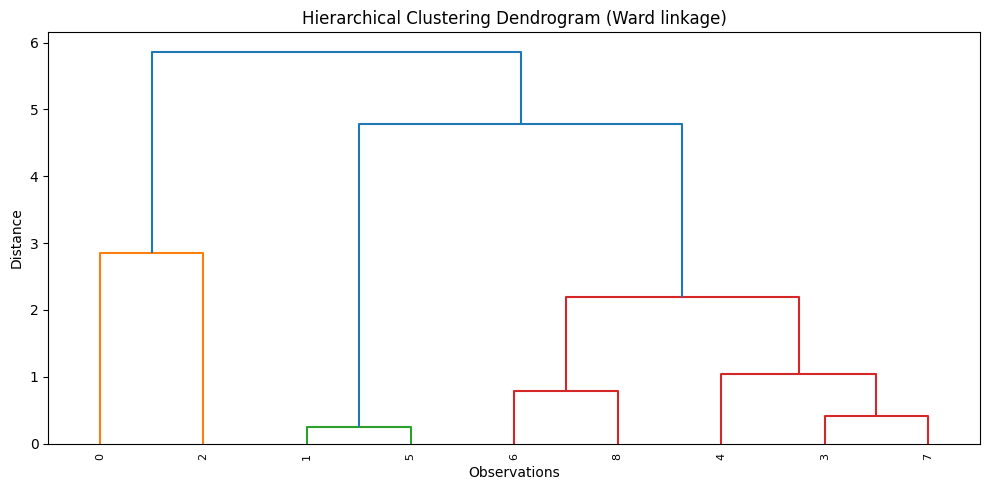

In [170]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

try:
    labels = feat_kat.index.astype(str)
except NameError:
    labels = None  # fallback if df_wide_staples isn't defined

# Ward linkage on the scaled data
Z = linkage(X_ts_scaled, method="ward")

plt.figure(figsize=(10, 5))
dendrogram(
    Z,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [162]:
# coba beberapa k buat sense-check, misal 2–4
for k in range(2, 5):
    km = KMeans(n_clusters=k, n_init=20, random_state=0)
    labels_k = km.fit_predict(X_ts_scaled)
    sil = silhouette_score(X_ts_scaled, labels_k)
    print(f"k = {k}, silhouette = {sil:.4f}")


k = 2, silhouette = 0.4283
k = 3, silhouette = 0.5400
k = 4, silhouette = 0.4963


In [163]:
best_k = 3

km_ts = KMeans(n_clusters=best_k, n_init=20, random_state=0)
labels_ts = km_ts.fit_predict(X_ts_scaled)

# gabung kembali ke vol_kat
ts_kat_clust = feat_kat.copy()
ts_kat_clust["ts_cluster"] = labels_ts

ts_kat_clust

,KategoriAgg,slope_log,r2_log,vol_ret_std,vol_ret_abs_mean,mean_log_ret,n_obs,ts_cluster
0,Bawang,0.006029,0.431100,0.075890,0.060019,0.006036,45.0,1
1,Beras,0.007144,0.865746,0.014505,0.010244,0.005376,45.0,2
2,Cabai,-0.000860,0.009859,0.102135,0.076668,-0.001150,45.0,1
3,Daging Ayam Ras,0.000308,0.015662,0.025013,0.020236,0.000052,45.0,0
4,Daging Sapi Murni,0.000501,0.209994,0.007903,0.004888,0.001593,45.0,0
5,Gula,0.007853,0.839268,0.014085,0.009699,0.005932,45.0,2
6,Jagung,0.003120,0.499486,0.018259,0.010404,0.002747,45.0,0
7,MinyakGoreng,0.000604,0.023959,0.020224,0.011201,0.000008,45.0,0
8,Telur Ayam Ras,0.002575,0.384250,0.032658,0.022024,0.002166,45.0,0


In [166]:
cluster_profile_ts = (
    ts_kat_clust
    .groupby("ts_cluster")[['vol_ret_std', 'vol_ret_abs_mean', 'mean_log_ret', 'slope_log', 'r2_log']]
    .mean()
    .rename_axis("ts_cluster")
)

cluster_profile_ts

,vol_ret_std,vol_ret_abs_mean,mean_log_ret,slope_log,r2_log
ts_cluster,,,,,
0,0.020811,0.013750,0.001313,0.001422,0.226670
1,0.089013,0.068344,0.002443,0.002584,0.220479
2,0.014295,0.009971,0.005654,0.007499,0.852507


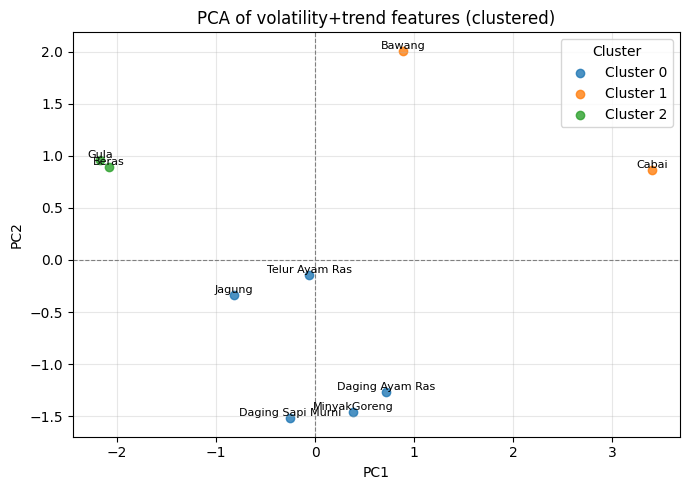

Explained variance ratio:
  PC1: 0.634
  PC2: 0.352

PCA loadings (correlation of each feature with PCs):
                  PC1_loading  PC2_loading
vol_ret_std          0.518307     0.474165
vol_ret_abs_mean     0.509984     0.490769
slope_log           -0.456600     0.563045
r2_log              -0.512631     0.466147


In [168]:
# ============================================
# 2. PCA to 2D for plotting
# ============================================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_ts_scaled)

ts_kat_clust["PC1"] = X_pca[:, 0]
ts_kat_clust["PC2"] = X_pca[:, 1]

# ============================================
# 3. Scatter plot of PC1 vs PC2 with clusters
# ============================================

plt.figure(figsize=(7, 5))

for c in sorted(ts_kat_clust["ts_cluster"].unique()):
    mask = ts_kat_clust["ts_cluster"] == c
    plt.scatter(
        ts_kat_clust.loc[mask, "PC1"],
        ts_kat_clust.loc[mask, "PC2"],
        label=f"Cluster {c}",
        alpha=0.8,
    )

# label each point with KategoriAgg
for _, row in ts_kat_clust.iterrows():
    plt.text(
        row["PC1"],
        row["PC2"],
        row["KategoriAgg"],
        fontsize=8,
        ha="center",
        va="bottom"
    )

plt.axhline(0, color="grey", linewidth=0.8, linestyle="--")
plt.axvline(0, color="grey", linewidth=0.8, linestyle="--")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of volatility+trend features (clustered)")
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# ============================================
# 4. PCA loadings: which variables build up PC1, PC2
# ============================================

loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols,
    columns=["PC1_loading", "PC2_loading"]
)

expl_var = pca.explained_variance_ratio_

print("Explained variance ratio:")
print(f"  PC1: {expl_var[0]:.3f}")
print(f"  PC2: {expl_var[1]:.3f}\n")

print("PCA loadings (correlation of each feature with PCs):")
print(loadings)

In [169]:
sil_ts = silhouette_score(X_ts_scaled, labels_ts)
ch_ts = calinski_harabasz_score(X_ts_scaled, labels_ts)
db_ts = davies_bouldin_score(X_ts_scaled, labels_ts)

print("=== KMeans (k=3) ===")
print(f"Silhouette score        : {sil_km:.4f}")
print(f"Calinski-Harabasz index : {ch_km:.4f}")
print(f"Davies-Bouldin index    : {db_km:.4f}")

=== KMeans (k=3) ===
Silhouette score        : 0.5239
Calinski-Harabasz index : 36.9209
Davies-Bouldin index    : 0.4310


# Interpretasi Klaster Gabungan Tren dan Volatilitas Harga Komoditas

Berikut interpretasi tiga klaster hasil pengelompokan berdasarkan empat dimensi:
- **vol_ret_std**  → volatilitas (simpangan baku log-return bulanan)
- **vol_ret_abs_mean** → rata-rata absolut perubahan log-return (besarnya perubahan tipikal per bulan)
- **slope_log** → kemiringan tren jangka panjang (laju kenaikan/penurunan harga rata-rata nasional)
- **r2_log** → kekuatan/kerapian tren linear dalam skala log (0–1)

## Ringkasan Profil Klaster

Tabel profil rata-rata per klaster:

- **Klaster 0**
  - `vol_ret_std` ≈ 0,0208  
  - `vol_ret_abs_mean` ≈ 0,0138  
  - `mean_log_ret` ≈ 0,0013  
  - `slope_log` ≈ 0,0014  
  - `r2_log` ≈ 0,227  

- **Klaster 1**
  - `vol_ret_std` ≈ 0,0890  
  - `vol_ret_abs_mean` ≈ 0,0683  
  - `mean_log_ret` ≈ 0,0024  
  - `slope_log` ≈ 0,0026  
  - `r2_log` ≈ 0,220  

- **Klaster 2**
  - `vol_ret_std` ≈ 0,0143  
  - `vol_ret_abs_mean` ≈ 0,0100  
  - `mean_log_ret` ≈ 0,0057  
  - `slope_log` ≈ 0,0075  
  - `r2_log` ≈ 0,853  

Berikut interpretasi masing-masing klaster.

---

## Klaster 0 – Tren Lemah, Volatilitas Rendah–Sedang

**Anggota:**  
- Daging Ayam Ras  
- Daging Sapi Murni  
- Jagung  
- Minyak Goreng  
- Telur Ayam Ras  

**Karakteristik utama:**

- **Volatilitas relatif rendah–sedang**  
  Nilai `vol_ret_std` dan `vol_ret_abs_mean` berada di kisaran menengah dan cukup homogen antar komoditas dalam klaster ini. Artinya, harga bergerak tetapi tanpa lonjakan bulanan yang ekstrem.

- **Tren jangka panjang cenderung lemah**  
  Nilai `slope_log` rata-rata kecil (~0,0014), yang mengindikasikan laju kenaikan harga bulanan yang relatif landai bila dibandingkan klaster lain. Kenaikannya ada, tetapi tidak sekuat komoditas pada klaster 2.

- **Kerapian tren moderat–rendah**  
  Nilai `r2_log` sekitar 0,23 menunjukkan bahwa meskipun ada kecenderungan naik, pola harga tidak sepenuhnya mengikuti garis tren yang mulus. Terdapat fluktuasi dan episode intervensi/pengaturan pasar atau shock jangka pendek yang membuat jalur harga “bergelombang”.

**Interpretasi substantif:**

Klaster ini merepresentasikan **komoditas dengan tren kenaikan harga yang relatif landai, disertai volatilitas yang terkendali**. Harga tidak se-stabil beras/gula, tetapi juga tidak se-liar cabai dan bawang. Komoditas dalam klaster ini cenderung:

- memiliki pergerakan harga yang **masih bisa diprediksi secara makro**,  
- namun dibumbui fluktuasi jangka pendek (musiman, biaya pakan, kebijakan, dsb.),  
- tanpa membentuk lonjakan harga yang dramatis dari bulan ke bulan.

---

## Klaster 1 – Komoditas Bumbu Volatil, Tren Lemah dan Kurang Rapi

**Anggota:**  
- Bawang  
- Cabai  

**Karakteristik utama:**

- **Volatilitas sangat tinggi**  
  Nilai `vol_ret_std` (~0,089) dan `vol_ret_abs_mean` (~0,068) jauh lebih besar dibanding dua klaster lain. Ini menunjukkan bahwa perubahan harga bulanan untuk bawang dan cabai **besar dan sering**, dengan banyak episode kenaikan/penurunan tajam.

- **Tren rata-rata hanya sedikit naik atau bahkan mendekati datar**  
  Rata-rata `slope_log` (~0,0026) relatif kecil. Secara rata-rata jangka panjang, harga memang cenderung naik, tetapi **trennya tidak sekuat dan sebersih beras/gula**. Untuk cabai, slope bahkan mendekati nol/negatif kecil, sehingga pergerakan jangka panjang lebih didominasi volatilitas daripada tren.

- **Kerapian tren rendah**  
  Nilai `r2_log` (~0,22) menunjukkan bahwa garis tren linear tidak menjelaskan variasi harga dengan baik. Artinya, dinamika harga bawang dan cabai **lebih banyak ditentukan oleh shock musiman, cuaca, dan gangguan pasokan**, bukan oleh kenaikan bertahap yang halus.

**Interpretasi substantif:**

Klaster ini menggambarkan **komoditas bumbu yang sangat sensitif terhadap faktor musiman dan gangguan pasokan**. Harga bawang dan cabai:

- menunjukkan **lonjakan dan koreksi tajam** (spike–crash) dari bulan ke bulan,  
- memiliki **tren jangka panjang yang tidak terlalu kuat/rapi**,  
- sulit diprediksi hanya dengan model tren linier sederhana.

Dari sudut pandang kebijakan, komoditas di klaster ini merupakan kandidat utama untuk:

- pemantauan stok dan distribusi yang lebih ketat,  
- intervensi ketika memasuki musim rawan (paceklik, hujan berkepanjangan, dsb.),  
- komunikasi risiko harga kepada konsumen dan pelaku pasar.

---

## Klaster 2 – Staples Sangat Stabil dengan Tren Naik yang Kuat dan Mulus

**Anggota:**  
- Beras  
- Gula  

**Karakteristik utama:**

- **Volatilitas rendah**  
  `vol_ret_std` (~0,0143) dan `vol_ret_abs_mean` (~0,010) adalah yang terendah di antara semua klaster. Ini menunjukkan bahwa **perubahan harga bulanan kecil dan relatif konsisten**.

- **Tren kenaikan harga kuat dan jelas**  
  `slope_log` (~0,0075) adalah yang tertinggi, dengan `mean_log_ret` (~0,0057) juga paling besar. Ini berarti beras dan gula memiliki **laju kenaikan harga bulanan yang lebih tinggi** dibanding komoditas lain, namun kenaikannya terjadi secara bertahap dan tidak meledak-ledak.

- **Kerapian tren sangat tinggi**  
  `r2_log` ≈ 0,85 menunjukkan bahwa sebagian besar variasi log-harga dapat dijelaskan oleh tren linear terhadap waktu. Dengan kata lain, harga beras dan gula **sangat mengikuti pola tren jangka panjang yang mulus**, dengan deviasi acak yang relatif kecil.

**Interpretasi substantif:**

Klaster ini adalah **inti komoditas pangan pokok yang sangat stabil namun konsisten mengalami kenaikan harga jangka panjang**. Pola ini konsisten dengan:

- adanya **intervensi dan regulasi harga** yang kuat,  
- mekanisme pasokan yang relatif lebih terstruktur,  
- prioritas tinggi dalam kebijakan ketahanan pangan.

Harga beras dan gula:

- jarang mengalami lonjakan besar bulanan,  
- tetapi **naik pelan namun pasti** sepanjang periode pengamatan,  
- sehingga memberikan sinyal tekanan inflasi jangka panjang yang stabil.

---

## Kesimpulan Singkat

Dengan menggabungkan dimensi **volatilitas** (std dan rata-rata absolut log-return) dan **tren** (slope dan R² log-harga), pengelompokan komoditas nasional menghasilkan tiga pola perilaku utama:

1. **Klaster 0 – Tren lemah, volatilitas rendah–sedang**  
   Komoditas hewani dan beberapa bahan pangan lain yang harganya bergerak tetapi tidak ekstrem, dengan tren kenaikan yang relatif landai dan pola yang tidak sepenuhnya mulus.

2. **Klaster 1 – Komoditas bumbu sangat volatil, tren lemah**  
   Bawang dan cabai dengan karakteristik pergerakan harga yang penuh lonjakan dan koreksi, tren jangka panjang yang kurang rapi, dan sangat dipengaruhi shock musiman.

3. **Klaster 2 – Staples sangat stabil dengan tren naik yang kuat**  
   Beras dan gula, sebagai komoditas pangan pokok yang cenderung mengalami kenaikan harga jangka panjang yang jelas, dengan volatilitas rendah dan pola tren yang sangat terstruktur.

Struktur klaster ini mendukung narasi bahwa **setiap kelompok komoditas memiliki profil risiko harga yang berbeda**, sehingga memerlukan pendekatan kebijakan dan strategi stabilisasi yang juga berbeda-beda.